<a href="https://colab.research.google.com/github/AnovaYoung/whatsmyshape/blob/main/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The Problem**: Malaria is a contagious disease caused by Plasmodium parasites that are transmitted to humans through the bites of infected female Anopheles mosquitoes.The parasites enter the blood and begin damaging red blood cells(RBCs)that carry oxygen,which can result in respiratory distress and other complications.
Traditional diagnosis of malaria in the laboratory requires careful inspection by an experienced professional to discriminate between healthy and infected red blood cells. It is a tedious, time-consuming process,and the diagnostic accuracy(which heavily depends on human expertise) can be adversely impacted by inter-observer variability.Anautomated system can help with the early and accurate detection of malaria.

**Objective**: Build an efficient computer vision model to detect malaria.The model should identify whether the image of a red blood cell is that of one infected with malaria or not,and classify the same as parasitized or uninfected, respectively

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(0)

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print("All libraries imported")

All libraries imported


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/cell_images.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Organize the images in 4D numpy arrays and create labels.

In [ ]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#path to our directories
train_data_dir = '/tmp/cell_images/train'
test_data_dir = '/tmp/cell_images/test'

img_width, img_height = 64, 64
#initialize the images
def preprocess_data(data_dir, num_samples):
  X = np.zeros((num_samples, img_width, img_height, 3))
  y = np.zeros((num_samples,))

  for label, class_name in enumerate(['Uninfected', 'Parasitized']):
    print(f'Processing {class_name} images...')
    dir_path = os.path.join(data_dir, class_name)
    class_images = os.listdir(dir_path)

    #enumerate over the images
    for i, image_name in enumerate(class_images):
      img = load_img(os.path.join(dir_path, image_name), target_size=(img_width, img_height))
      X[i] = img_to_array(img)
      y[i] = label

      X/=255.0 #normalize array, pixel = 0-1

      return X,y



In [ ]:
!ls /tmp


cell_images
dap_multiplexer.2b314f5acc36.root.log.INFO.20230803-021640.85
dap_multiplexer.INFO
debugger_ngm7yanqc
directoryprefetcher_binary.2b314f5acc36.root.log.INFO.20230803-022021.1202
directoryprefetcher_binary.INFO
drive.2b314f5acc36.root.log.ERROR.20230803-022019.1117
drive.2b314f5acc36.root.log.INFO.20230803-022014.1028
drive.2b314f5acc36.root.log.INFO.20230803-022014.1035
drive.2b314f5acc36.root.log.INFO.20230803-022019.1028
drive.2b314f5acc36.root.log.INFO.20230803-022019.1117
drive.2b314f5acc36.root.log.WARNING.20230803-022019.1117
drive.ERROR
drivefs_ipc.0
drivefs_ipc.0_shell
drive.INFO
drive.WARNING
initgoogle_syslog_dir.0
language_service.2b314f5acc36.root.log.INFO.20230803-021725.318
language_service.INFO
pyright-323-1CGI1FNrNNsS
pyright-323-QupJZ4hmY7qU
python-languageserver-cancellation


Assigning values

In [ ]:
!ls /tmp/cell_images/train
!ls /tmp/cell_images/test

parasitized  uninfected
parasitized  uninfected


In [ ]:
train_data_dir = '/tmp/cell_images/train'
test_data_dir = '/tmp/cell_images/test'

parasitized_images = os.listdir(os.path.join(train_data_dir, 'parasitized'))
uninfected_images = os.listdir(os.path.join(train_data_dir, 'uninfected'))


Retrieving shape/info of test and train data

In [ ]:

def print_dataset_info(data_dir):
    categories = ['parasitized', 'uninfected']
    for category in categories:
        num_images = len(os.listdir(os.path.join(data_dir, category)))
        print(f'Number of {category} images in {data_dir}: {num_images}')

print_dataset_info(train_data_dir)
print_dataset_info(test_data_dir)


Number of parasitized images in /tmp/cell_images/train: 12582
Number of uninfected images in /tmp/cell_images/train: 12376
Number of parasitized images in /tmp/cell_images/test: 1300
Number of uninfected images in /tmp/cell_images/test: 1300


We see roughly 200 more images in the *training* set of the 'parasitized' cells than the training set of the 'uninfected' cells.
subsequently, the aforementioned images for the *test* sets are equal at 1300.

Loading and Processing Training Data

In [ ]:
import os
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array


train_images = []
train_labels = []

parasitized_dir = '/tmp/cell_images/train/parasitized'
uninfected_dir = '/tmp/cell_images/train/uninfected'

#infected images
for filename in os.listdir(parasitized_dir):
    try:
        image_path = os.path.join(parasitized_dir, filename)
        image = load_img(image_path, target_size=(64, 64))
        image = img_to_array(image)
        train_images.append(image)
        train_labels.append(1)  # Parasitized cells are labelled as 1
    except Exception as e:

        print(f'Error processing file {filename}: {e}')

        pass

# uninfected images
for filename in os.listdir(uninfected_dir):
    try:
        image_path = os.path.join(uninfected_dir, filename)
        image = load_img(image_path, target_size=(64, 64))
        image = img_to_array(image)
        train_images.append(image)
        train_labels.append(0)  # Uninfected cells are labelled as 0
    except Exception as e:
        print(f'Error processing file {filename}: {e}')
        pass

# Convert to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)


Loading and processing Test Data

In [ ]:

test_images = []
test_labels = []


parasitized_dir = '/tmp/cell_images/test/parasitized'
uninfected_dir = '/tmp/cell_images/test/uninfected'


for filename in os.listdir(parasitized_dir):
    try:
        image_path = os.path.join(parasitized_dir, filename)
        image = load_img(image_path, target_size=(64, 64))
        image = img_to_array(image)
        test_images.append(image)
        test_labels.append(1)
    except Exception as e:
        print(f'Error processing file {filename}: {e}')
        pass

for filename in os.listdir(uninfected_dir):
    try:
        image_path = os.path.join(uninfected_dir, filename)
        image = load_img(image_path, target_size=(64, 64))
        image = img_to_array(image)
        test_images.append(image)
        test_labels.append(0)
    except Exception as e:
        print(f'Error processing file {filename}: {e}')
        pass

test_images = np.array(test_images)
test_labels = np.array(test_labels)


In [ ]:
print(f'Shape of training data: {train_images.shape}')
print(f'Shape of training labels: {train_labels.shape}')


Shape of training data: (24958, 64, 64, 3)
Shape of training labels: (24958,)


In [ ]:
print(f'Shape of test data: {test_images.shape}')
print(f'Shape of test labels: {test_labels.shape}')


Shape of test data: (2600, 64, 64, 3)
Shape of test labels: (2600,)


The shapes of the data indicate that the dataset has been correctly set up for input to a Convolutional Neural Network.

Understanding min and max pixel values

In [ ]:
#Train images
print('Train images:')
print('Min pixel value:', train_images.min())
print('Max pixel value:', train_images.max())

# Test images
print('Test images:')
print('Min pixel value:', test_images.min())
print('Max pixel value:', test_images.max())


Train images:
Min pixel value: 0.0
Max pixel value: 255.0
Test images:
Min pixel value: 0.0
Max pixel value: 255.0


Sum of values in uninfected and parasitized

In [ ]:
# training data
num_train_parasitized = np.sum(train_labels == 1)
num_train_uninfected = np.sum(train_labels == 0)

# test data
num_test_parasitized = np.sum(test_labels == 1)
num_test_uninfected = np.sum(test_labels == 0)

print(f'Training data: {num_train_parasitized} parasitized and {num_train_uninfected} uninfected')
print(f'Test data: {num_test_parasitized} parasitized and {num_test_uninfected} uninfected')


Training data: 12582 parasitized and 12376 uninfected
Test data: 1300 parasitized and 1300 uninfected


Normalize Images (Intensity value, range 0-1)

In [ ]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


Using a visualization technique can help more clearly define if data is balanced or unbalanced.

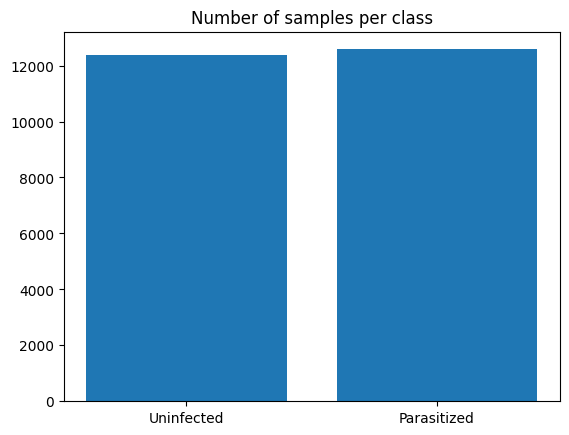

In [ ]:
import matplotlib.pyplot as plt

classes, counts = np.unique(train_labels, return_counts=True)
# Create a bar plot
plt.bar(classes, counts, tick_label=['Uninfected', 'Parasitized'])
plt.title('Number of samples per class')

plt.show()

Seemingly very balanced data as the difference between the bars in minimal.

DATA EXPLORATION

Visualize Data from Train data.

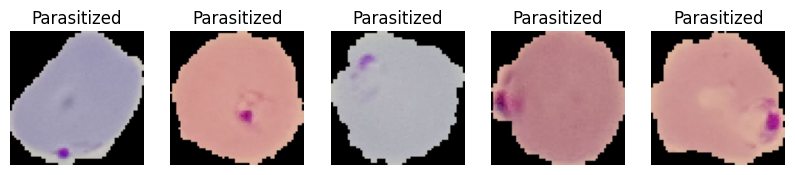

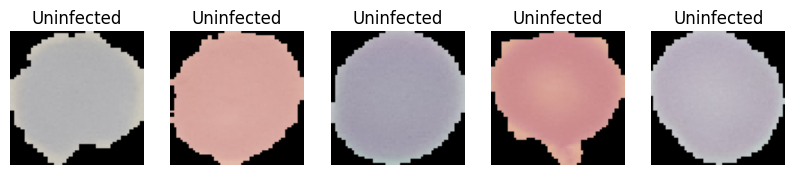

In [28]:
import matplotlib.pyplot as plt

#first few images of parasitized cells
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = train_images[train_labels == 1][i]
    plt.imshow(img)
    plt.title('Parasitized')
    plt.axis('off')
plt.show()

#first few images of uninfected cells
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = train_images[train_labels == 0][i]
    plt.imshow(img)
    plt.title('Uninfected')
    plt.axis('off')
plt.show()


In the parasitized cells discoloration can be observed in a purple hugh of slightly different shapes and sizes. The purple shapes are mostly circular. The uninfected images have no other shapes and colors inside them and are a smooth consistency in their coloring.

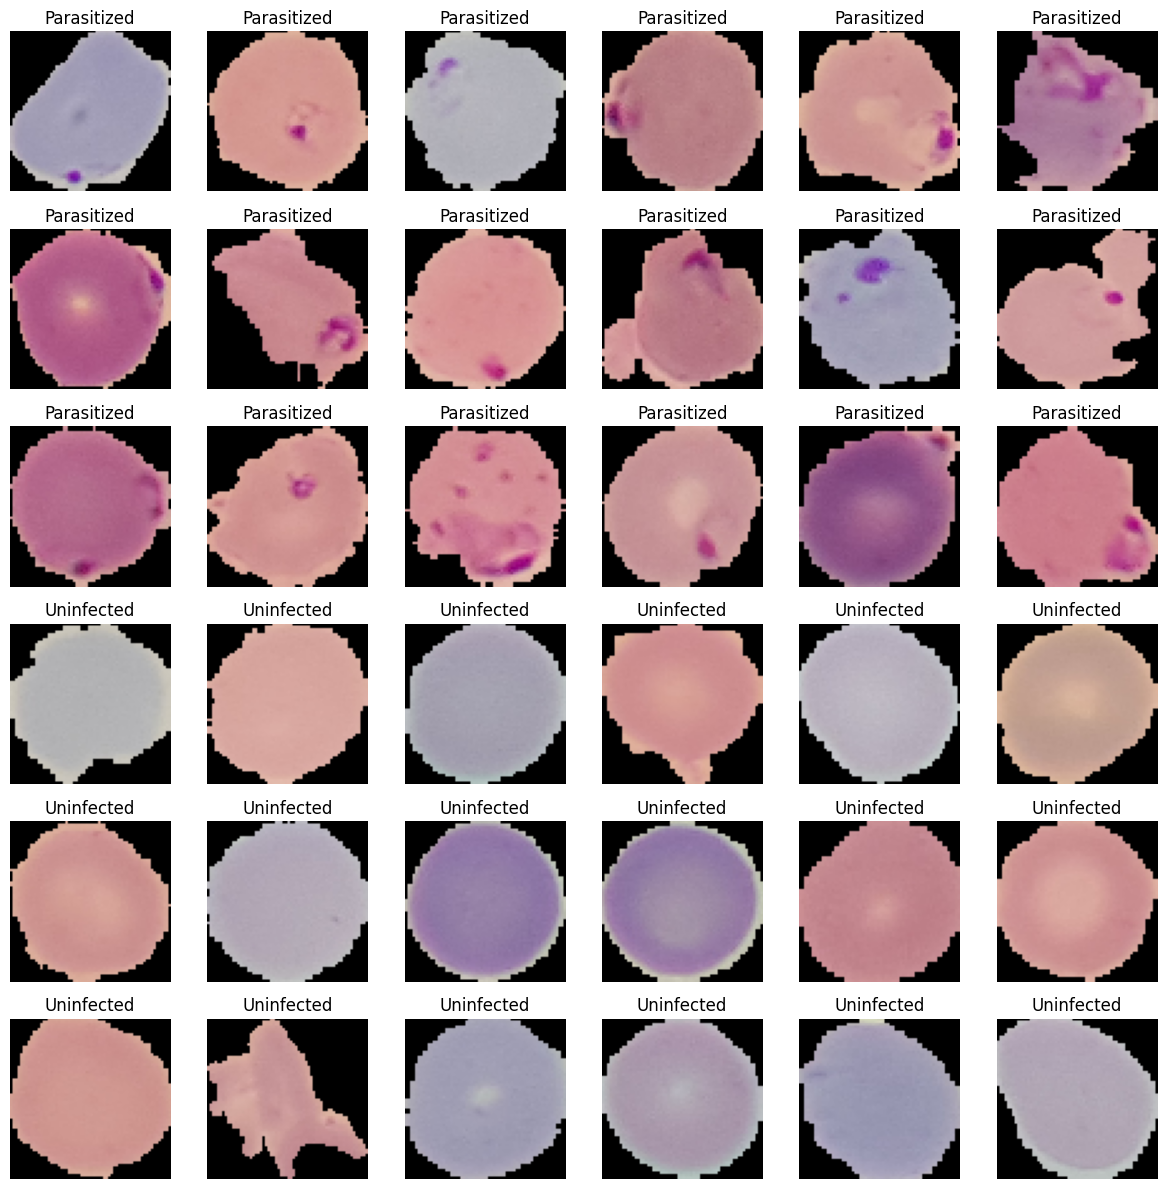

In [29]:
plt.figure(figsize=(12,12))

# Display 18 parasitized images
for i in range(18):
    plt.subplot(6,6,i+1)
    img = train_images[train_labels == 1][i]
    plt.imshow(img)
    plt.title('Parasitized')
    plt.axis('off')

# Display 18 uninfected images
for i in range(18,36):
    plt.subplot(6,6,i+1)
    img = train_images[train_labels == 0][i-18]
    plt.imshow(img)
    plt.title('Uninfected')
    plt.axis('off')

plt.tight_layout()#provides good/adequate spacing between the images

plt.show()


Plot mean images for parasitized and uninfected